## Default import and settings

In [53]:
import numpy as np
import pandas as pd
import re
from os.path import join

from tools import *

from sklearn.decomposition import LatentDirichletAllocation
from scipy.spatial import distance

import matplotlib.pyplot as plt
import numpy as np

## rename EXTRACT_FEATURES to DIMENSION_REDUCTION
read_prefix = "/data/MIMIC3/"
write_prefix = "/data/liu/LDA"
res_prefix = "/data/liu/LDA/lda_result"
res_r_prefix = "/data/liu/LDA/lda_R_result/"
## for this notebook
save_prefix = "/data/liu/LDA/topic_cluster_analysis"

In [2]:
## Reading R LDA results
pres_n_comp=10
diag_n_comp=10

prefix = 'ngib700_ncomp10'

# Default number of clusters for R results: 10
pres_Z = read_data(join(res_r_prefix,prefix,"pres_theta"))
pres_Z = pres_Z.values

pres_Y = read_data(join(res_r_prefix,prefix,"pres_phi"))
pres_Y = pres_Y.values

diag_Y = read_data(join(res_r_prefix,prefix,"diag_phi"))
diag_Y = diag_Y.values

diag_Z = read_data(join(res_r_prefix,prefix,"diag_theta"))
diag_Z = diag_Z.values

## Cluster analysis on LDA result

In [3]:
##  each topic subgroup (column), compare patient characteristics(age, gender, mortality, length of stay, top diseases, top drugs
pres_patient = read_data(join(write_prefix,"pres_patient"))
diag_patient = read_data(join(write_prefix,"diag_patient"))


In [4]:
pres_thetadf = pd.DataFrame(data=np.c_[pres_patient.iloc[:,0].astype(int),pres_Z],\
                            columns=['SUBJECT_ID']+["C%d"%i for i in range(10)])
diag_thetadf = pd.DataFrame(data=np.c_[diag_patient.iloc[:,0].astype(int),diag_Z],\
                           columns=['SUBJECT_ID']+["C%d"%i for i in range(10)])

In [5]:
## soft clustring probs -> binary value (df[c_i]>df[c_i].mean)
def df_binary(df):
    col_mean= df.mean(axis=0)
    for col in ["C%d"%i for i in range(10)]:
        df[col]=np.where(df[col]>=col_mean[col], 1, 0)
    return df.astype(int)

In [6]:
pres_thetadf = df_binary(pres_thetadf)
diag_thetadf=df_binary(diag_thetadf)

In [7]:
pres_thetadf.head()

,SUBJECT_ID,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9
0,2,0,0,1,0,0,0,0,0,0,0
1,4,1,0,1,1,0,0,0,0,0,0
2,6,1,0,1,1,0,0,0,0,0,0
3,8,1,0,1,0,0,0,0,0,0,0
4,9,0,0,1,1,1,0,0,0,0,0


### Common Function

In [8]:
def match_patientTopic2characs(characs_col, df, patient_topic_df,null='',patient_list= pres_patient['SUBJECT_ID']):
    
    ## Groupby subject_id&hadm_id, but randomly selected hadm_ids for filtered pres_matrix are not recorded, maybe better to use hadm_id to run cluster analysis
    df_characs = df[['SUBJECT_ID',characs_col]]
    if(null!=''):
        df_characs=df_characs[df_characs[characs_col]!=null]
    
    df_characs = df_characs[df_characs['SUBJECT_ID'].isin(patient_list)].drop_duplicates()
    
    df_characs_c = left_join(df_characs, patient_topic_df,'SUBJECT_ID')
    return df_characs_c

In [9]:
def getTopItems(characs_col, df_characs_c, top_n=10,pres_n_comp=pres_n_comp):
    ## number of top drugs need to be generated from each topics
    result = []
    for i in range(pres_n_comp):
        cluster_id = 'C%d'%i
        df_ci = df_characs_c[df_characs_c[cluster_id]==1][[characs_col]]
        top_items = df_ci[characs_col].value_counts()[:top_n].index.to_list()
        result = result+[[cluster_id]+top_items]
        
    return result

In [10]:
def to_datetime(pd_col,date_format="%Y-%m-%d %H:%M:%S"):
    return pd.to_datetime(pd_col,format=date_format)

In [40]:
def remove_microsec(time):
    return str(time).split(".")[0]

### TOP DRUGS

In [9]:
pres_df = read_data(join(read_prefix,"PRESCRIPTIONS"),dtype={'NDC':str})
pres_df.head()

/home/liu/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


,ROW_ID,SUBJECT_ID,HADM_ID,ICUSTAY_ID,STARTDATE,ENDDATE,DRUG_TYPE,DRUG,DRUG_NAME_POE,DRUG_NAME_GENERIC,FORMULARY_DRUG_CD,GSN,NDC,PROD_STRENGTH,DOSE_VAL_RX,DOSE_UNIT_RX,FORM_VAL_DISP,FORM_UNIT_DISP,ROUTE
0,2214776,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Tacrolimus,Tacrolimus,Tacrolimus,TACR1,021796,00469061711,1mg Capsule,2,mg,2,CAP,PO
1,2214775,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Warfarin,Warfarin,Warfarin,WARF5,006562,00056017275,5mg Tablet,5,mg,1,TAB,PO
2,2215524,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Heparin Sodium,NaN,NaN,HEPAPREMIX,006522,00338055002,"25,000 unit Premix Bag","25,000",UNIT,1,BAG,IV
3,2216265,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,BASE,D5W,NaN,NaN,HEPBASE,NaN,0,HEPARIN BASE,250,ml,250,ml,IV
4,2214773,6,107064,NaN,2175-06-11 00:00:00,2175-06-12 00:00:00,MAIN,Furosemide,Furosemide,Furosemide,FURO20,008208,00054829725,20mg Tablet,20,mg,1,TAB,PO


In [100]:
pres_df_ndc_c= match_patientTopic2characs('NDC',pres_df,pres_thetadf,'0')
pres_df_ndc_c

,SUBJECT_ID,NDC,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9
0,6,00469061711,1,0,1,1,0,0,0,0,0,0
1,6,00056017275,1,0,1,1,0,0,0,0,0,0
2,6,00338055002,1,0,1,1,0,0,0,0,0,0
3,6,00054829725,1,0,1,1,0,0,0,0,0,0
4,6,00056016975,1,0,1,1,0,0,0,0,0,0


In [22]:
## number of top drugs need to be generated from each topics
# top_n=10
# result = []
# for i in range(pres_n_comp):
#     cluster_id = 'C%d'%i
#     pres_ci = pres_df_ndc_c[pres_df_ndc_c[cluster_id]==1][['NDC']]
#     top_items = pres_ci['NDC'].value_counts()[:top_n].index.to_list()
#     result = result+[[cluster_id]+top_items]

In [105]:
result = getTopItems('NDC',pres_df_ndc_c)
result[0]

['C0',
 '00338004904',
 '00008084199',
 '00338004903',
 '00338004902',
 '00641040025',
 '63323026201',
 '00338001702',
 '00338004938',
 '00409672924',
 '00904516561']

In [29]:
pres_topitems = pd.DataFrame(data=result, columns=["TOPIC"]+["TOP_%d"%i for i in range(top_n)])
write2file(pres_topitems,join(save_prefix,"%d_top_drugs"%top_n))

In [62]:
## check whether top drugs found in lda clusters have overlapped with top 10 drugs with most ADEs from sider database
top10_NDC_ade = read_data(join(write_prefix,'top10_NDC_ade'),dtype={'NDC':str})

## replace ndc with drug index from set of top drugs of all topics
pres_topitems_druglist = list(set(np.array(result)[:,1:].flatten()))
topitems_map = {}

for i in range(11,11+len(pres_topitems_druglist)):
    topitems_map[pres_topitems_druglist[i-11]]="drug_%d"%i
def ndc_2_drugindex(ndc):
    return topitems_map[ndc]

pres_topitems_drugindex = pres_topitems.set_index('TOPIC').apply(np.vectorize(ndc_2_drugindex)).reset_index()
write2file(pres_topitems_drugindex,join(save_prefix,"%d_top_drugs_index"%top_n))

In [8]:
pres_topitems_drugindex = read_data(join(save_prefix,"10_top_drugs_index"))
pres_topitems_drugindex

,TOPIC,TOP_0,TOP_1,TOP_2,TOP_3,TOP_4,TOP_5,TOP_6,TOP_7,TOP_8,TOP_9
0,C0,drug_31,drug_40,drug_32,drug_13,drug_22,drug_26,drug_17,drug_30,drug_37,drug_27
1,C1,drug_26,drug_31,drug_37,drug_32,drug_27,drug_21,drug_13,drug_25,drug_42,drug_19
2,C2,drug_17,drug_32,drug_31,drug_40,drug_13,drug_30,drug_22,drug_26,drug_14,drug_28
3,C3,drug_22,drug_17,drug_40,drug_18,drug_13,drug_29,drug_14,drug_32,drug_30,drug_41
4,C4,drug_17,drug_18,drug_30,drug_14,drug_15,drug_12,drug_40,drug_33,drug_38,drug_22
5,C5,drug_37,drug_26,drug_31,drug_17,drug_32,drug_42,drug_34,drug_21,drug_30,drug_13
6,C6,drug_37,drug_34,drug_30,drug_17,drug_21,drug_11,drug_35,drug_23,drug_14,drug_19
7,C7,drug_17,drug_14,drug_30,drug_11,drug_20,drug_39,drug_23,drug_24,drug_35,drug_16
8,C8,drug_37,drug_34,drug_17,drug_30,drug_14,drug_21,drug_36,drug_11,drug_39,drug_35
9,C9,drug_17,drug_14,drug_30,drug_13,drug_32,drug_42,drug_31,drug_40,drug_18,drug_20


In [47]:
ndc_drug = read_data(join(read_prefix,"PRESCRIPTIONS"),dtype={'NDC':str,'DRUG':str})[['NDC','DRUG']].drop_duplicates()
ndc_drug.head()

/home/liu/anaconda3/envs/py36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


,NDC,DRUG
0,00469061711,Tacrolimus
1,00056017275,Warfarin
2,00338055002,Heparin Sodium
3,0,D5W
4,00054829725,Furosemide


In [49]:
ndc_drug_map = dict(zip(ndc_drug.NDC, ndc_drug.DRUG))

In [74]:
pres_topitems10= read_data(join(save_prefix,"%d_top_drugs"%10),\
                           dtype = dict(zip(["TOP_%d"%i for i in range(10)],[str]*10)))
pres_topitems10

,TOPIC,TOP_0,TOP_1,TOP_2,TOP_3,TOP_4,TOP_5,TOP_6,TOP_7,TOP_8,TOP_9
0,C0,00338004904,00008084199,00338004903,00338004902,00641040025,63323026201,00338001702,00338004938,00409672924,00904516561
1,C1,63323026201,00338004904,00409672924,00338004903,00904516561,00904224461,00338004902,00182844789,00338355248,00574705050
2,C2,00338001702,00338004903,00338004904,00008084199,00338004902,00338004938,00641040025,63323026201,00338070341,63323038810
3,C3,00641040025,00338001702,00008084199,00517391025,00338004902,00517260225,00338070341,00338004903,00338004938,58177000111
4,C4,00338001702,00517391025,00338004938,00338070341,00045050130,00074407532,00008084199,00074610204,51079001920,00641040025
5,C5,00409672924,63323026201,00338004904,00338001702,00338004903,00338355248,00409490234,00904224461,00338004938,00338004902
6,C6,00409672924,00409490234,00338004938,00338001702,00904224461,00338011704,00121054410,51079025520,00338070341,00574705050
7,C7,00338001702,00338070341,00338004938,00338011704,00002821501,10019016312,51079025520,00904404073,00121054410,00713016550
8,C8,00409672924,00409490234,00338001702,00338004938,00338070341,00904224461,54569523500,00338011704,10019016312,00121054410
9,C9,00338001702,00338070341,00338004938,00338004902,00338004903,00338355248,00338004904,00008084199,00517391025,00002821501


In [76]:
pres_topitems10.iloc[:,1:11] = pres_topitems10.iloc[:,1:11].applymap(lambda x: ndc_drug_map[str(x)])
pres_topitems10

,TOPIC,TOP_0,TOP_1,TOP_2,TOP_3,TOP_4,TOP_5,TOP_6,TOP_7,TOP_8,TOP_9
0,C0,0.9% Sodium Chloride,panto,Sodium Chloride 0.9 % or No Intervention,NS Epidural Bag (0.9% NaCl),Heparin CRRT,Heparin CRRT,NS,D5W,Magnesium,Senna
1,C1,Heparin CRRT,0.9% Sodium Chloride,Magnesium,Sodium Chloride 0.9 % or No Intervention,Senna,Docusa,NS Epidural Bag (0.9% NaCl),Acetaminop,Vancomycin,Biscolax
2,C2,NS,Sodium Chloride 0.9 % or No Intervention,0.9% Sodium Chloride,panto,NS Epidural Bag (0.9% NaCl),D5W,Heparin CRRT,Heparin CRRT,POTASSIUM CHLORIDE,NEO*IV*AMPicillin Sodium
3,C3,Heparin CRRT,NS,panto,NEO*IV*Parenteral Nutrition,NS Epidural Bag (0.9% NaCl),Magnesium Sulfate Replacement (Critical Care a...,POTASSIUM CHLORIDE,Sodium Chloride 0.9 % or No Intervention,D5W,potass
4,C4,NS,NEO*IV*Parenteral Nutrition,D5W,POTASSIUM CHLORIDE,ACETAM,Potassium Chloride,panto,Metoprolol,Docusate,Heparin CRRT
5,C5,Magnesium,Heparin CRRT,0.9% Sodium Chloride,NS,Sodium Chloride 0.9 % or No Intervention,Vancomycin,dextr,Docusa,D5W,NS Epidural Bag (0.9% NaCl)
6,C6,Magnesium,dextr,D5W,NS,Docusa,Lactated Ringers,Docusate S,Metoprolol,POTASSIUM CHLORIDE,Biscolax
7,C7,NS,POTASSIUM CHLORIDE,D5W,Lactated Ringers,HumuLIN R,phenylephrine HCl,Metoprolol,Aspirin 81 mg /Placebo,Docusate S,Acetaminop
8,C8,Magnesium,dextr,NS,D5W,POTASSIUM CHLORIDE,Docusa,Chlorhexidine Gluconate,Lactated Ringers,phenylephrine HCl,Docusate S
9,C9,NS,POTASSIUM CHLORIDE,D5W,NS Epidural Bag (0.9% NaCl),Sodium Chloride 0.9 % or No Intervention,Vancomycin,0.9% Sodium Chloride,panto,NEO*IV*Parenteral Nutrition,HumuLIN R


### TOP DISEASES

In [9]:
diag_df = read_data(join(read_prefix,"DIAGNOSES_ICD"),dtype={'ICD9_CODE':str})
diag_df.head()

,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


In [13]:
diag_df_icd9_c= match_patientTopic2characs('ICD9_CODE',diag_df,pres_thetadf)
diag_df_icd9_c.head()

,SUBJECT_ID,ICD9_CODE,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9
0,109,40301,1,1,1,0,0,0,0,0,0,0
1,109,486,1,1,1,0,0,0,0,0,0,0
2,109,58281,1,1,1,0,0,0,0,0,0,0
3,109,5855,1,1,1,0,0,0,0,0,0,0
4,109,4254,1,1,1,0,0,0,0,0,0,0


In [18]:
result5 = getTopItems('ICD9_CODE',diag_df_icd9_c,top_n=5)
diag_topitems = pd.DataFrame(data=result5, columns=["TOPIC"]+["TOP_%d"%i for i in range(5)])
diag_topitems

,TOPIC,TOP_0,TOP_1,TOP_2,TOP_3,TOP_4
0,C0,4019,4280,5849,42731,41401
1,C1,4019,2724,42731,4280,5849
2,C2,4019,V290,V053,4280,42731
3,C3,4019,4280,42731,41401,5849
4,C4,4019,41401,4280,42731,2720
5,C5,4019,42731,51881,5849,4280
6,C6,4019,41401,2724,42731,4280
7,C7,41401,4019,42731,2724,4280
8,C8,41401,4019,2724,42731,4280
9,C9,4019,4280,51881,42731,41401


In [19]:
# result10 = getTopItems('ICD9_CODE',diag_df_icd9_c,top_n=10)
diag_topitems10 = pd.DataFrame(data=result10, columns=["TOPIC"]+["TOP_%d"%i for i in range(10)])
diag_topitems10

,TOPIC,TOP_0,TOP_1,TOP_2,TOP_3,TOP_4,TOP_5,TOP_6,TOP_7,TOP_8,TOP_9
0,C0,4019,4280,5849,42731,41401,2724,25000,51881,53081,5990
1,C1,4019,2724,42731,4280,5849,41401,25000,51881,5990,53081
2,C2,4019,V290,V053,4280,42731,7742,5849,41401,51881,25000
3,C3,4019,4280,42731,41401,5849,51881,25000,5990,486,2720
4,C4,4019,41401,4280,42731,2720,25000,51881,5849,5990,41071
5,C5,4019,42731,51881,5849,4280,2724,41401,25000,5990,99592
6,C6,4019,41401,2724,42731,4280,25000,53081,5849,2859,2720
7,C7,41401,4019,42731,2724,4280,25000,2720,4241,53081,4240
8,C8,41401,4019,2724,42731,4280,25000,4241,53081,2859,E8782
9,C9,4019,4280,51881,42731,41401,5849,99592,25000,5990,486


In [21]:
write2file(diag_topitems10,join(save_prefix,"%d_top_diseases"%10))

In [23]:
icd9_name = read_data(join(read_prefix,"D_ICD_DIAGNOSES"),dtype={'ICD9_CODE':str})[['ICD9_CODE','SHORT_TITLE']]
icd9_name.head()

,ICD9_CODE,SHORT_TITLE
0,01166,TB pneumonia-oth test
1,01170,TB pneumothorax-unspec
2,01171,TB pneumothorax-no exam
3,01172,TB pneumothorx-exam unkn
4,01173,TB pneumothorax-micro dx


In [42]:
icd9_name_map = dict(zip(icd9_name.ICD9_CODE, icd9_name.SHORT_TITLE))

In [43]:
diag_topitems10 = read_data(join(save_prefix,"%d_top_diseases"%10),\
                            dtype=dict(zip(["TOPIC_%d"%i for i in range(10)],[str]*10)))
diag_topitems10

,TOPIC,TOP_0,TOP_1,TOP_2,TOP_3,TOP_4,TOP_5,TOP_6,TOP_7,TOP_8,TOP_9
0,C0,4019,4280,5849,42731,41401,2724,25000,51881,53081,5990
1,C1,4019,2724,42731,4280,5849,41401,25000,51881,5990,53081
2,C2,4019,V290,V053,4280,42731,7742,5849,41401,51881,25000
3,C3,4019,4280,42731,41401,5849,51881,25000,5990,486,2720
4,C4,4019,41401,4280,42731,2720,25000,51881,5849,5990,41071
5,C5,4019,42731,51881,5849,4280,2724,41401,25000,5990,99592
6,C6,4019,41401,2724,42731,4280,25000,53081,5849,2859,2720
7,C7,41401,4019,42731,2724,4280,25000,2720,4241,53081,4240
8,C8,41401,4019,2724,42731,4280,25000,4241,53081,2859,E8782
9,C9,4019,4280,51881,42731,41401,5849,99592,25000,5990,486


In [44]:
def code2name(code):
    return icd9_name_map[code]

In [45]:
## applymap: 
diag_topitems10.iloc[:,1:11] = diag_topitems10.iloc[:,1:11].applymap(lambda x: code2name(str(x)))
diag_topitems10

,TOPIC,TOP_0,TOP_1,TOP_2,TOP_3,TOP_4,TOP_5,TOP_6,TOP_7,TOP_8,TOP_9
0,C0,Hypertension NOS,CHF NOS,Acute kidney failure NOS,Atrial fibrillation,Crnry athrscl natve vssl,Hyperlipidemia NEC/NOS,DMII wo cmp nt st uncntr,Acute respiratry failure,Esophageal reflux,Urin tract infection NOS
1,C1,Hypertension NOS,Hyperlipidemia NEC/NOS,Atrial fibrillation,CHF NOS,Acute kidney failure NOS,Crnry athrscl natve vssl,DMII wo cmp nt st uncntr,Acute respiratry failure,Urin tract infection NOS,Esophageal reflux
2,C2,Hypertension NOS,NB obsrv suspct infect,Need prphyl vc vrl hepat,CHF NOS,Atrial fibrillation,Neonat jaund preterm del,Acute kidney failure NOS,Crnry athrscl natve vssl,Acute respiratry failure,DMII wo cmp nt st uncntr
3,C3,Hypertension NOS,CHF NOS,Atrial fibrillation,Crnry athrscl natve vssl,Acute kidney failure NOS,Acute respiratry failure,DMII wo cmp nt st uncntr,Urin tract infection NOS,"Pneumonia, organism NOS",Pure hypercholesterolem
4,C4,Hypertension NOS,Crnry athrscl natve vssl,CHF NOS,Atrial fibrillation,Pure hypercholesterolem,DMII wo cmp nt st uncntr,Acute respiratry failure,Acute kidney failure NOS,Urin tract infection NOS,"Subendo infarct, initial"
5,C5,Hypertension NOS,Atrial fibrillation,Acute respiratry failure,Acute kidney failure NOS,CHF NOS,Hyperlipidemia NEC/NOS,Crnry athrscl natve vssl,DMII wo cmp nt st uncntr,Urin tract infection NOS,Severe sepsis
6,C6,Hypertension NOS,Crnry athrscl natve vssl,Hyperlipidemia NEC/NOS,Atrial fibrillation,CHF NOS,DMII wo cmp nt st uncntr,Esophageal reflux,Acute kidney failure NOS,Anemia NOS,Pure hypercholesterolem
7,C7,Crnry athrscl natve vssl,Hypertension NOS,Atrial fibrillation,Hyperlipidemia NEC/NOS,CHF NOS,DMII wo cmp nt st uncntr,Pure hypercholesterolem,Aortic valve disorder,Esophageal reflux,Mitral valve disorder
8,C8,Crnry athrscl natve vssl,Hypertension NOS,Hyperlipidemia NEC/NOS,Atrial fibrillation,CHF NOS,DMII wo cmp nt st uncntr,Aortic valve disorder,Esophageal reflux,Anemia NOS,Abn react-anastom/graft
9,C9,Hypertension NOS,CHF NOS,Acute respiratry failure,Atrial fibrillation,Crnry athrscl natve vssl,Acute kidney failure NOS,Severe sepsis,DMII wo cmp nt st uncntr,Urin tract infection NOS,"Pneumonia, organism NOS"


In [37]:
code2name('4019')

'Hypertension NOS'

### Gender

In [11]:
patient_df = read_data(join(read_prefix,"PATIENTS"))
patient_df['DOB']=to_datetime(patient_df['DOB'])
patient_df.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG
0,234,249,F,2075-03-13,NaN,NaN,NaN,0
1,235,250,F,2164-12-27,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1
2,236,251,M,2090-03-15,NaN,NaN,NaN,0
3,237,252,M,2078-03-06,NaN,NaN,NaN,0
4,238,253,F,2089-11-26,NaN,NaN,NaN,0


In [12]:
patient_gender_c = match_patientTopic2characs("GENDER",patient_df,pres_thetadf)
patient_gender_c.head()

,SUBJECT_ID,GENDER,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9
0,249,F,0,0,0,1,0,0,0,0,0,0
1,250,F,0,0,0,1,0,0,0,0,0,0
2,251,M,1,0,1,0,0,0,0,0,0,0
3,252,M,0,0,0,1,0,0,0,0,0,0
4,253,F,1,0,1,1,0,0,0,0,0,0


In [26]:
characs_col = "GENDER"
df_characs_c = patient_gender_c

result = []
for i in range(pres_n_comp):
    cluster_id = 'C%d'%i
    df_ci = df_characs_c[df_characs_c[cluster_id]==1][[characs_col]]
    percentage = df_ci[characs_col].value_counts(normalize=True)*100    
    result = result+[[cluster_id,"%.2f%%"%percentage['M'],"%.2f%%"%percentage['F']]]

In [27]:
gender_percentage = pd.DataFrame(data=result, columns=["TOPIC","Male","Female"])
gender_percentage

,TOPIC,Male,Female
0,C0,55.02%,44.98%
1,C1,53.38%,46.62%
2,C2,54.65%,45.35%
3,C3,54.91%,45.09%
4,C4,59.33%,40.67%
5,C5,57.03%,42.97%
6,C6,60.34%,39.66%
7,C7,67.82%,32.18%
8,C8,67.14%,32.86%
9,C9,58.26%,41.74%


In [28]:
write2file(gender_percentage,join(save_prefix,"gender_percentage"))

### Mortality

In [31]:
patient_death_c = match_patientTopic2characs("EXPIRE_FLAG",patient_df,pres_thetadf)
patient_death_c.head()

,SUBJECT_ID,EXPIRE_FLAG,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9
0,249,0,0,0,0,1,0,0,0,0,0,0
1,250,1,0,0,0,1,0,0,0,0,0,0
2,251,0,1,0,1,0,0,0,0,0,0,0
3,252,0,0,0,0,1,0,0,0,0,0,0
4,253,0,1,0,1,1,0,0,0,0,0,0


In [36]:
characs_col = "EXPIRE_FLAG"
df_characs_c = patient_death_c

result = []
for i in range(pres_n_comp):
    cluster_id = 'C%d'%i
    df_ci = df_characs_c[df_characs_c[cluster_id]==1][[characs_col]]
    mortality = df_ci[characs_col].mean()*100
    result = result+[[cluster_id,"%.2f%%"%mortality]]

In [37]:
mortality = pd.DataFrame(data=result, columns=["TOPIC","mortality"])
mortality

,TOPIC,mortality
0,C0,36.33%
1,C1,36.38%
2,C2,33.08%
3,C3,55.75%
4,C4,47.48%
5,C5,38.86%
6,C6,21.33%
7,C7,17.74%
8,C8,12.77%
9,C9,55.37%


In [38]:
write2file(mortality,join(save_prefix,"mortality"))

### AGE

In [46]:
admission_df = read_data(join(read_prefix,"ADMISSIONS"))[['SUBJECT_ID','HADM_ID','ADMITTIME','DISCHTIME']]
admission_df[['ADMITTIME','DISCHTIME']]=admission_df[['ADMITTIME','DISCHTIME']].apply(to_datetime)
admission_df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00
1,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00
2,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00
3,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00
4,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00


In [92]:
## too slow
# def get_first_record(df,col='ADMITTIME'):
#     return df.nsmallest(1,col)


In [69]:
## keep the first admission record for each patient
admission_df['LATEST_ADMITTIME'] = admission_df.groupby('SUBJECT_ID')['ADMITTIME'].transform('min')
admission_df=admission_df[admission_df['ADMITTIME']==admission_df['LATEST_ADMITTIME']][['SUBJECT_ID','ADMITTIME','DISCHTIME']]
admission_df.head()

,SUBJECT_ID,ADMITTIME,DISCHTIME
0,22,2196-04-09 12:26:00,2196-04-10 15:54:00
1,23,2153-09-03 07:15:00,2153-09-08 19:10:00
3,24,2139-06-06 16:14:00,2139-06-09 12:48:00
4,25,2160-11-02 02:06:00,2160-11-05 14:55:00
5,26,2126-05-06 15:16:00,2126-05-13 15:00:00


In [70]:
patient_ad_df = left_join(patient_df,admission_df[['SUBJECT_ID','ADMITTIME']],'SUBJECT_ID')
patient_ad_df.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,ADMITTIME
0,234,249,F,2075-03-13,NaN,NaN,NaN,0,2149-12-17 20:41:00
1,235,250,F,2164-12-27,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1,2188-11-12 09:22:00
2,236,251,M,2090-03-15,NaN,NaN,NaN,0,2110-07-27 06:46:00
3,237,252,M,2078-03-06,NaN,NaN,NaN,0,2133-03-31 04:24:00
4,238,253,F,2089-11-26,NaN,NaN,NaN,0,2174-01-21 20:58:00


In [71]:
patient_ad_df['AGE']= patient_ad_df['ADMITTIME'].subtract(patient_ad_df['DOB']).dt.days//365
patient_ad_df.head()

,ROW_ID,SUBJECT_ID,GENDER,DOB,DOD,DOD_HOSP,DOD_SSN,EXPIRE_FLAG,ADMITTIME,AGE
0,234,249,F,2075-03-13,NaN,NaN,NaN,0,2149-12-17 20:41:00,74.0
1,235,250,F,2164-12-27,2188-11-22 00:00:00,2188-11-22 00:00:00,NaN,1,2188-11-12 09:22:00,23.0
2,236,251,M,2090-03-15,NaN,NaN,NaN,0,2110-07-27 06:46:00,20.0
3,237,252,M,2078-03-06,NaN,NaN,NaN,0,2133-03-31 04:24:00,55.0
4,238,253,F,2089-11-26,NaN,NaN,NaN,0,2174-01-21 20:58:00,84.0


In [72]:
## patients who are older than 89 all get -285 for age 
patient_age_c = match_patientTopic2characs("AGE",patient_ad_df,pres_thetadf,null=-285)
patient_age_c.head()

,SUBJECT_ID,AGE,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9
0,249,74.0,0,0,0,1,0,0,0,0,0,0
1,250,23.0,0,0,0,1,0,0,0,0,0,0
2,251,20.0,1,0,1,0,0,0,0,0,0,0
3,252,55.0,0,0,0,1,0,0,0,0,0,0
4,253,84.0,1,0,1,1,0,0,0,0,0,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6f23cfaba8>]],
      dtype=object)

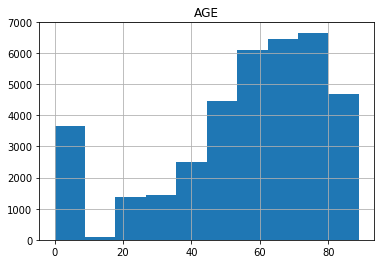

In [73]:
patient_age_c[['AGE']].hist()

In [35]:
patient_age_c['AGE'].max()

89

In [74]:
characs_col = "AGE"
df_characs_c=patient_age_c 

result = []
for i in range(pres_n_comp):
    cluster_id = 'C%d'%i
    df_ci = df_characs_c[df_characs_c[cluster_id]==1][[characs_col]]
    age_mean = df_ci[characs_col].mean()
    age_std = df_ci[characs_col].std()
    result = result+[[cluster_id,"%.2f ± %.2f"%(age_mean,age_std)]]

In [75]:
age = pd.DataFrame(data=result, columns=["TOPIC","AGE"])
age

,TOPIC,AGE
0,C0,53.23 ± 25.17
1,C1,62.25 ± 17.02
2,C2,42.83 ± 31.03
3,C3,61.92 ± 17.07
4,C4,62.91 ± 16.10
5,C5,62.42 ± 16.11
6,C6,61.34 ± 18.50
7,C7,65.32 ± 12.83
8,C8,66.34 ± 12.40
9,C9,62.03 ± 16.06


In [76]:
write2file(age,join(save_prefix,"age_mean"))

### Length of Stay

In [64]:
# admission_df = admission_df[admission_df['DISCHTIME']>admission_df['ADMITTIME']]
admission_df['LENGTH_STAY']=(admission_df['DISCHTIME']-admission_df['ADMITTIME']).dt.total_seconds()/86400
admission_df.head()

,SUBJECT_ID,ADMITTIME,DISCHTIME,LENGTH_STAY
0,22,2196-04-09 12:26:00,2196-04-10 15:54:00,1.144444
1,23,2153-09-03 07:15:00,2153-09-08 19:10:00,5.496528
3,24,2139-06-06 16:14:00,2139-06-09 12:48:00,2.856944
4,25,2160-11-02 02:06:00,2160-11-05 14:55:00,3.534028
5,26,2126-05-06 15:16:00,2126-05-13 15:00:00,6.988889


In [65]:
admission_df_c = match_patientTopic2characs("LENGTH_STAY", admission_df, pres_thetadf)
admission_df_c.head()

,SUBJECT_ID,LENGTH_STAY,C0,C1,C2,C3,C4,C5,C6,C7,C8,C9
0,23,5.496528,1,1,0,0,0,0,0,0,0,0
1,24,2.856944,1,0,0,1,0,0,0,0,0,0
2,25,3.534028,1,0,0,1,0,0,0,0,0,0
3,26,6.988889,0,0,1,1,1,0,0,0,0,0
4,27,2.686806,1,0,1,0,0,0,0,0,0,0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6f2881f9b0>]],
      dtype=object)

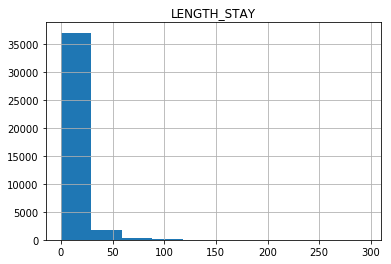

In [78]:
admission_df_c[['LENGTH_STAY']].hist()

In [66]:
characs_col = "LENGTH_STAY"
df_characs_c=admission_df_c

result = []
for i in range(pres_n_comp):
    cluster_id = 'C%d'%i
    df_ci = df_characs_c[df_characs_c[cluster_id]==1][[characs_col]]
    stay_mean = df_ci[characs_col].mean()
    stay_std = df_ci[characs_col].std()
    result = result+[[cluster_id,"%.2f ± %.2f"%(stay_mean,stay_std)]]

In [67]:
stay = pd.DataFrame(data=result, columns=["TOPIC","STAY"])
stay

,TOPIC,STAY
0,C0,6.30 ± 6.84
1,C1,9.36 ± 9.15
2,C2,11.00 ± 16.28
3,C3,12.61 ± 12.91
4,C4,11.00 ± 11.26
5,C5,14.16 ± 13.09
6,C6,9.02 ± 8.40
7,C7,9.91 ± 8.76
8,C8,10.03 ± 8.25
9,C9,17.80 ± 16.77


In [68]:
write2file(stay,join(save_prefix,"stay_mean"))